In [33]:
pip install pandas numpy seaborn matplotlib pymorphy2 scikit-learn tqdm natasha iterative-stratification lightgbm wordcloud

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 10.8 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [wordcloud]
   ---------------------------------------- 2/2 [wordcloud]

Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd

df = pd.read_csv("разметка комментариев 2.csv")

df.shape


(2373, 8)

In [35]:
# Удаление дубликатов 
df = df.drop_duplicates(subset='comment')

df.shape  


(1812, 8)

In [36]:
df.to_csv("разметка_без_дубликатов.csv", index=False)
print("Файл сохранен как 'разметка_без_дубликатов.csv'")


Файл сохранен как 'разметка_без_дубликатов.csv'


In [37]:
from natasha import Segmenter, NewsEmbedding, NewsMorphTagger, Doc

# Инициализация моделей Natasha
segmenter = Segmenter()
embedding = NewsEmbedding()
morph_tagger = NewsMorphTagger(embedding)

# Лемматизация текста
def lemmatize_text(text):
    doc = Doc(str(text).lower())
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    lemmas = [_.lemma for _ in doc.tokens if _.pos != 'PUNCT' and len(_.text) > 2]
    return lemmas

# Ключевые слова по категориям
keyword_map = {
    "Нравится скорость отработки заявок": ["быстро", "оперативно", "скорость"],
    "Нравится качество выполнения заявки": ["качественно", "отлично", "хорошо"],
    "Нравится качество работы сотрудников": ["вежливо", "спасибо", "благодарю", "профессионально", "мастер", "специалист", "сотрудник"],
    "Понравилось выполнение заявки": ["выполнить", "сделать", "хорошо", "спасибо", "благодарю"],
    "Вопрос решен": ["решить", "устранить", "помочь", "закрыть", "выполнить"]
}

# Классификация комментария по ключевым словам
def classify_comment(comment):
    lemmas = lemmatize_text(comment)
    result = {}
    for category, keywords in keyword_map.items():
        result[category] = int(any(word in lemmas for word in keywords))
    return result


In [38]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pandas as pd

# Загружаем твой CSV
df = pd.read_csv("readyrazmet.csv")

# Заполняем пропуски нулями, если они есть
label_cols = [
    "Нравится скорость отработки заявок",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Понравилось выполнение заявки",
    "Вопрос решен"
]
df[label_cols] = df[label_cols].fillna(0).astype(int)

# Добавим колонку для фолда
df["fold"] = -1

# Разбиваем на 5 стратифицированных фолдов
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = df["comment"]
y = df[label_cols].values

for fold, (train_idx, val_idx) in enumerate(mskf.split(X, y)):
    df.loc[val_idx, "fold"] = fold

# Сохраняем результат
df.to_csv("разметка_с_фолдами.csv", index=False)
print("Разбивка по фолдам готова.")


Разбивка по фолдам готова.


In [39]:
import pandas as pd
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

tqdm.pandas()
morph = pymorphy2.MorphAnalyzer()

# Лемматизация
def lemmatize_text(text):
    words = str(text).lower().split()
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return " ".join(lemmas)

# Загрузка размеченного CSV
df = pd.read_csv("readyrazmet.csv")  
df.dropna(subset=["comment"], inplace=True)

# Лемматизация текста
df["lemmatized"] = df["comment"].progress_apply(lemmatize_text)

# Векторизация TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df["lemmatized"])

# Целевые переменные
target_columns = [col for col in df.columns if col not in ["comment", "lemmatized", "id", "rating"]]

y = df[target_columns]

print(f"Матрица признаков: {X.shape}")
print(f"Целевые переменные: {y.shape}")


100%|██████████| 1812/1812 [00:03<00:00, 580.38it/s]

Матрица признаков: (1812, 5000)
Целевые переменные: (1812, 6)


In [40]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.preprocessing import MultiLabelBinarizer

# Загружаем файл с фолдами
df = pd.read_csv("разметка_с_фолдами.csv")

# Столбец с текстом
X_text = df["comment"].fillna("")

# Целевые колонки (мультилабе́ль)
label_cols = [
    "Нравится скорость отработки заявок",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Понравилось выполнение заявки",
    "Вопрос решен"
]
y = df[label_cols].fillna(0).astype(int)

# Обучим TF-IDF на всех текстах
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X_text)

from sklearn.metrics import f1_score

# Результаты
scores = []

# Предсказания для всех фолдов (можно сохранить)
oof_preds = np.zeros_like(y)

for fold in sorted(df["fold"].unique()):
    print(f"\n🧪 Fold {fold}")
    
    train_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
    y_train, y_val = y.loc[train_idx], y.loc[val_idx]

    # Модель
    model = OneVsRestClassifier(LogisticRegression(max_iter=1000, C=1.0))
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    oof_preds[val_idx] = preds

    f1 = f1_score(y_val, preds, average="micro")
    print("F1 score (micro):", round(f1, 4))
    scores.append(f1)

print("\n🎯 Средний F1 (micro):", round(np.mean(scores), 4))

print("\n📋 Classification report:")
print(classification_report(y, oof_preds, target_names=label_cols, zero_division=0))



🧪 Fold 0
F1 score (micro): 0.5869

🧪 Fold 1
F1 score (micro): 0.5935

🧪 Fold 2
F1 score (micro): 0.6494

🧪 Fold 3
F1 score (micro): 0.5805

🧪 Fold 4
F1 score (micro): 0.6242

🎯 Средний F1 (micro): 0.6069

📋 Classification report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.84      0.41      0.55       389
 Нравится качество выполнения заявки       0.62      0.10      0.17        99
Нравится качество работы сотрудников       0.89      0.55      0.68       664
       Понравилось выполнение заявки       0.85      0.55      0.67       725
                        Вопрос решен       1.00      0.10      0.18       154

                           micro avg       0.86      0.47      0.61      2031
                           macro avg       0.84      0.34      0.45      2031
                        weighted avg       0.86      0.47      0.59      2031
                         samples avg       0.32      0.28      0.

C:\Users\jacke\AppData\Local\Temp\ipykernel_10136\938020541.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


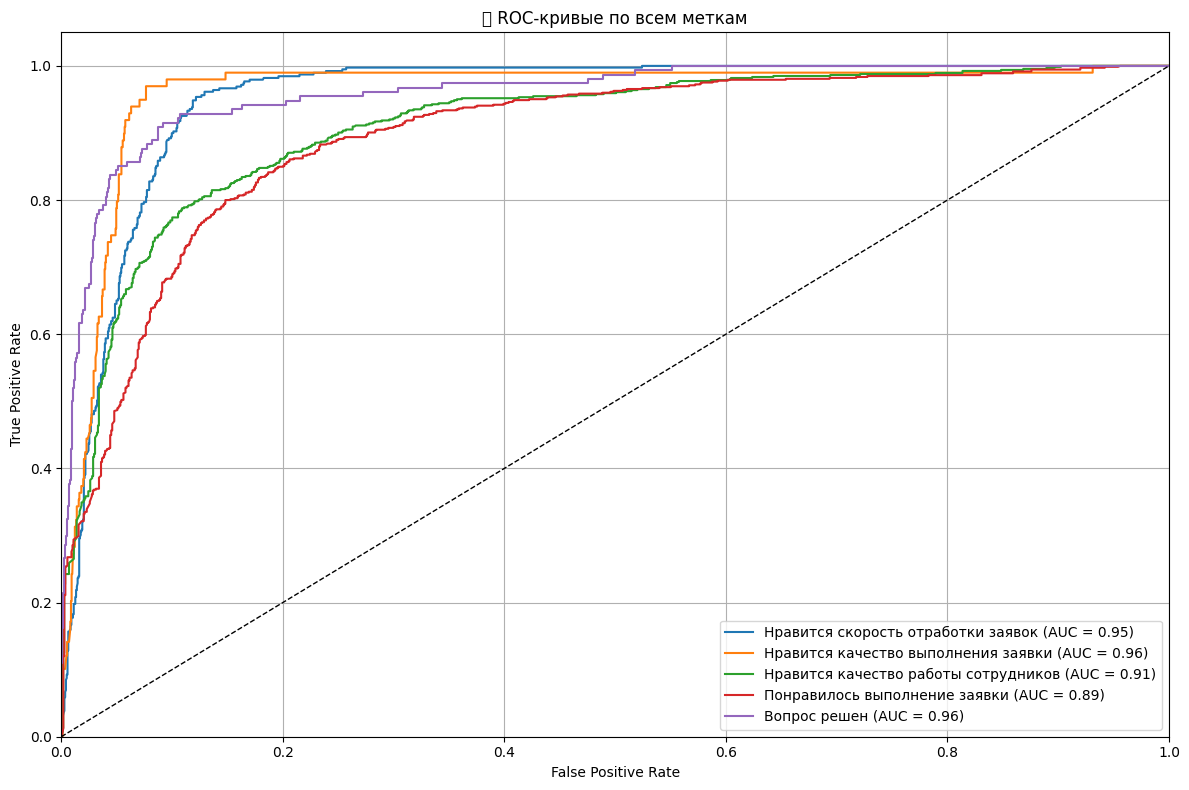

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Переобучаем модель с сохранением вероятностей на out-of-fold
oof_proba = np.zeros_like(y, dtype=float)

for fold in sorted(df["fold"].unique()):
    train_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
    y_train, y_val = y.loc[train_idx], y.loc[val_idx]

    model = OneVsRestClassifier(LogisticRegression(max_iter=1000, C=1.0))
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_val)
    oof_proba[val_idx] = probs

# Строим ROC-кривые по каждой категории
from sklearn.preprocessing import label_binarize

plt.figure(figsize=(12, 8))

for i, col in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(y.iloc[:, i], oof_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{col} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC-кривые по всем меткам')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()



🧪 Fold 0 — LightGBM
[LightGBM] [Info] Number of positive: 312, number of negative: 1138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215172 -> initscore=-1.294024
[LightGBM] [Info] Start training from score -1.294024
[LightGBM] [Info] Number of positive: 79, number of negative: 1371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 69
[Light

c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 score (micro): 0.7136

🧪 Fold 1 — LightGBM
[LightGBM] [Info] Number of positive: 311, number of negative: 1139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1492
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214483 -> initscore=-1.298113
[LightGBM] [Info] Start training from score -1.298113
[LightGBM] [Info] Number of positive: 79, number of negative: 1371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1492
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054483 -> initscore=-2.853848
[LightGBM] [Info] Start train

c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 score (micro): 0.7397

🧪 Fold 2 — LightGBM
[LightGBM] [Info] Number of positive: 311, number of negative: 1138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 1449, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214631 -> initscore=-1.297235
[LightGBM] [Info] Start training from score -1.297235
[LightGBM] [Info] Number of positive: 79, number of negative: 1370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 1449, number of

c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 score (micro): 0.7663

🧪 Fold 3 — LightGBM
[LightGBM] [Info] Number of positive: 311, number of negative: 1138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 1449, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214631 -> initscore=-1.297235
[LightGBM] [Info] Start training from score -1.297235
[LightGBM] [Info] Number of positive: 80, number of negative: 1369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 1449, number of

c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 score (micro): 0.7519

🧪 Fold 4 — LightGBM
[LightGBM] [Info] Number of positive: 311, number of negative: 1139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214483 -> initscore=-1.298113
[LightGBM] [Info] Start training from score -1.298113
[LightGBM] [Info] Number of positive: 79, number of negative: 1371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 1450, number of

c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\jacke\AppData\Local\Temp\ipykernel_10136\3060439735.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


F1 score (micro): 0.771

📋 Classification report (LightGBM):
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.75      0.76      0.76       389
 Нравится качество выполнения заявки       0.49      0.35      0.41        99
Нравится качество работы сотрудников       0.82      0.75      0.78       664
       Понравилось выполнение заявки       0.79      0.77      0.78       725
                        Вопрос решен       0.72      0.55      0.62       154

                           micro avg       0.77      0.72      0.75      2031
                           macro avg       0.71      0.64      0.67      2031
                        weighted avg       0.77      0.72      0.75      2031
                         samples avg       0.46      0.43      0.43      2031



c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


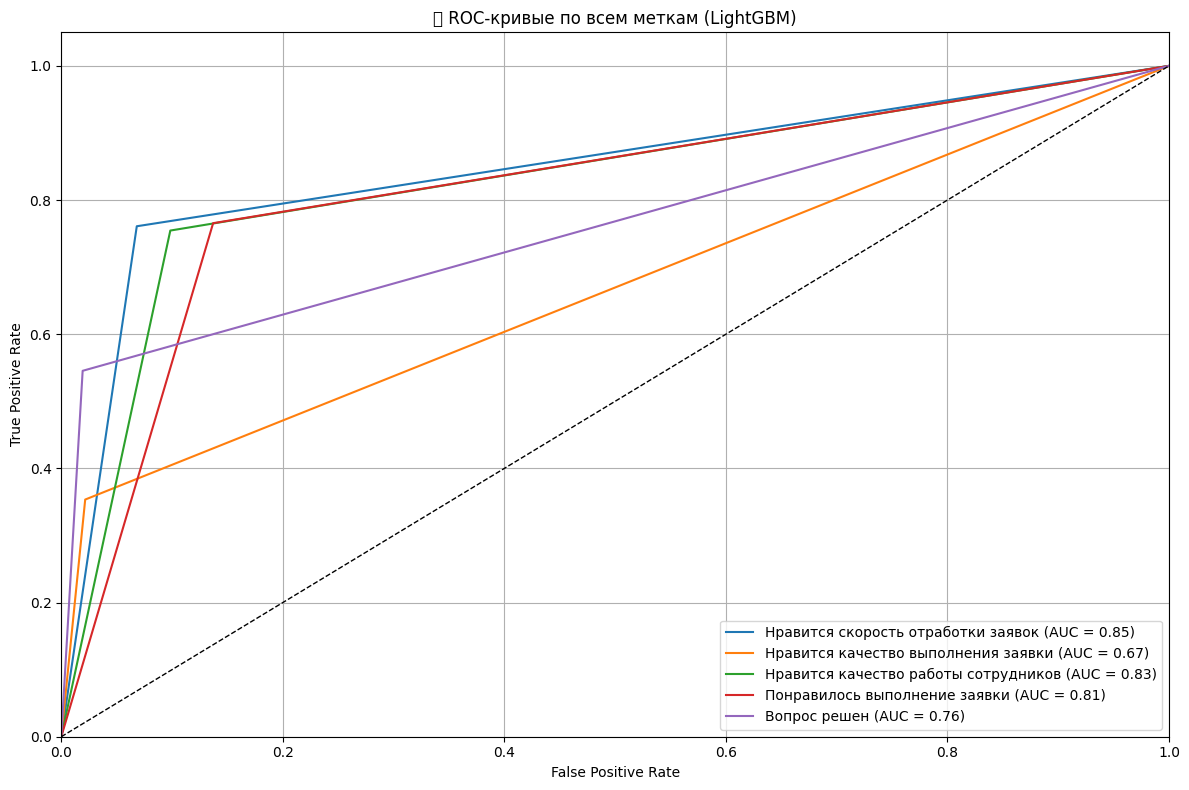

In [43]:
import lightgbm as lgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report, roc_curve, auc

# Создаем такую же структуру, как до этого
oof_preds_lgb = np.zeros_like(y)

for fold in sorted(df["fold"].unique()):
    print(f"\n🧪 Fold {fold} — LightGBM")

    train_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
    y_train, y_val = y.loc[train_idx], y.loc[val_idx]

    model = OneVsRestClassifier(
        lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1)
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    oof_preds_lgb[val_idx] = preds

    f1 = f1_score(y_val, preds, average="micro")
    print("F1 score (micro):", round(f1, 4))

print("\n📋 Classification report (LightGBM):")
print(classification_report(y, oof_preds_lgb, target_names=label_cols, zero_division=0))

plt.figure(figsize=(12, 8))

for i, col in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(y.iloc[:, i], oof_preds_lgb[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{col} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC-кривые по всем меткам (LightGBM)')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


C:\Users\jacke\AppData\Local\Temp\ipykernel_10136\2334898760.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


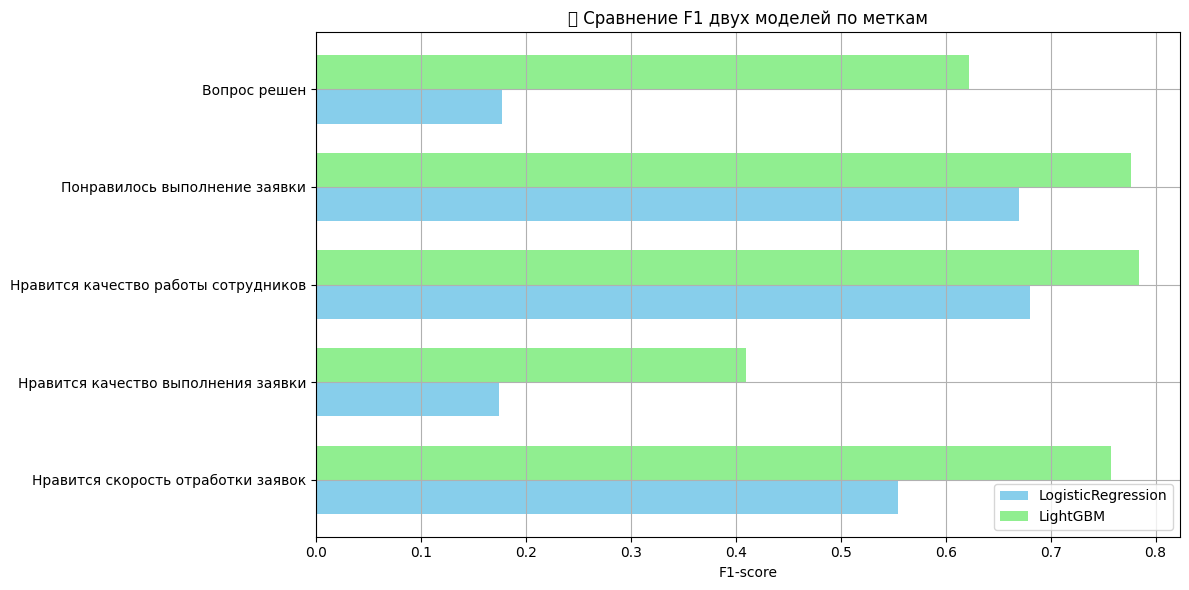

In [44]:
from sklearn.metrics import f1_score

# Считаем F1 по каждой категории
f1_logreg = [f1_score(y.iloc[:, i], oof_preds[:, i]) for i in range(len(label_cols))]
f1_lgb = [f1_score(y.iloc[:, i], oof_preds_lgb[:, i]) for i in range(len(label_cols))]

# Построение графика
x = np.arange(len(label_cols))
width = 0.35

plt.figure(figsize=(12, 6))
plt.barh(x - width/2, f1_logreg, width, label='LogisticRegression', color='skyblue')
plt.barh(x + width/2, f1_lgb, width, label='LightGBM', color='lightgreen')
plt.yticks(x, label_cols)
plt.xlabel("F1-score")
plt.title("📊 Сравнение F1 двух моделей по меткам")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\jacke\AppData\Local\Temp\ipykernel_10136\2187207923.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


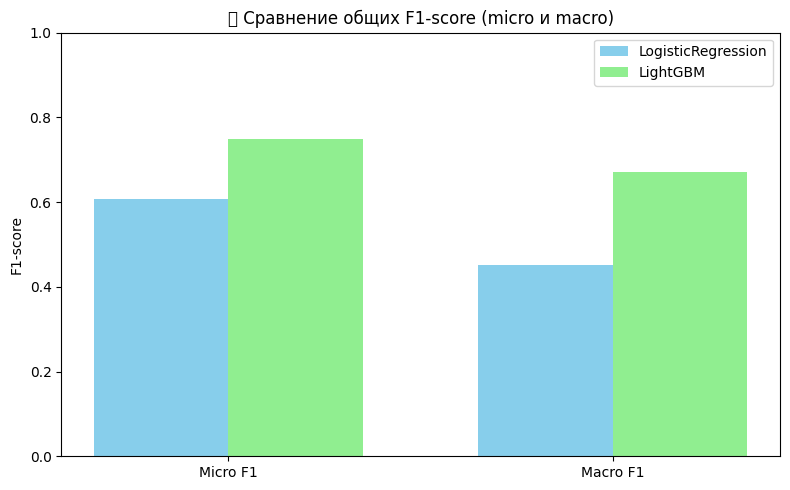

In [46]:
f1_micro_log = f1_score(y, oof_preds, average='micro')
f1_micro_lgb = f1_score(y, oof_preds_lgb, average='micro')

f1_macro_log = f1_score(y, oof_preds, average='macro')
f1_macro_lgb = f1_score(y, oof_preds_lgb, average='macro')

# График
labels = ['Micro F1', 'Macro F1']
logreg_scores = [f1_micro_log, f1_macro_log]
lgb_scores = [f1_micro_lgb, f1_macro_lgb]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, logreg_scores, width, label='LogisticRegression', color='skyblue')
plt.bar(x + width/2, lgb_scores, width, label='LightGBM', color='lightgreen')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("📊 Сравнение общих F1-score (micro и macro)")
plt.legend()
plt.tight_layout()
plt.show()


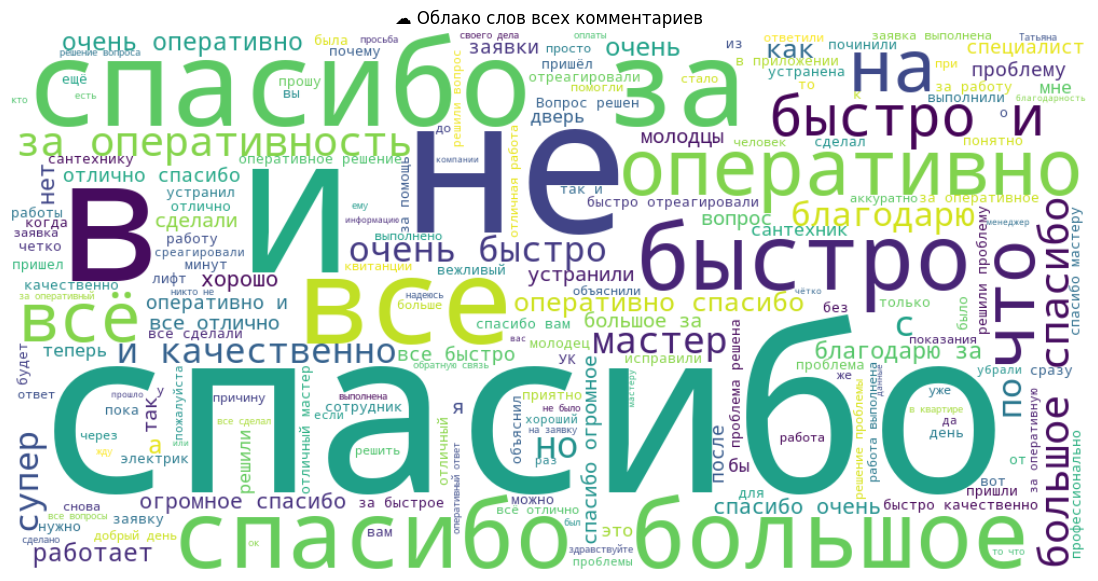

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Объединяем все комментарии
text = " ".join(str(t) for t in df["comment"].dropna())

# Создаем облако
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                      colormap='viridis', max_words=200).generate(text)

# Отображаем
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("☁️ Облако слов всех комментариев")
plt.show()


C:\Users\jacke\AppData\Local\Temp\ipykernel_10136\2721406532.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jacke\OneDrive\Рабочий стол\intens4\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


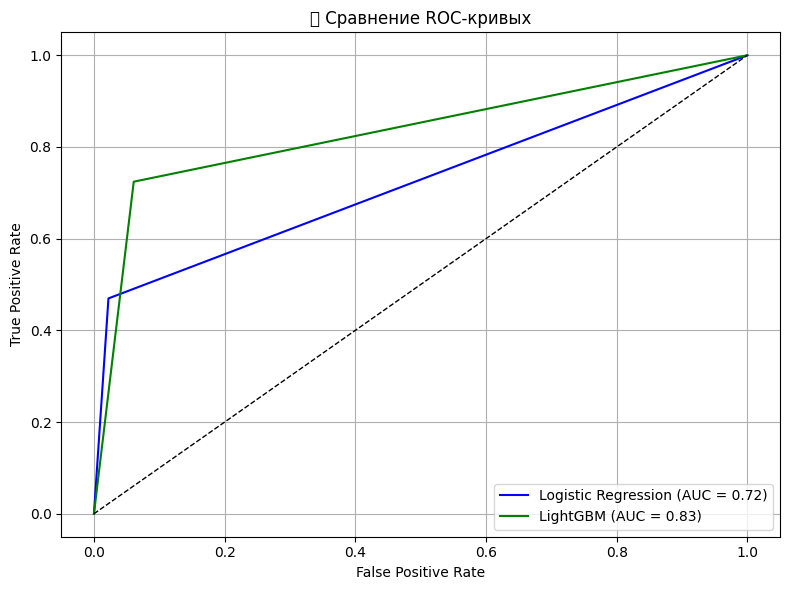

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Micro-avg ROC: LogisticRegression
fpr_log, tpr_log, _ = roc_curve(y.values.ravel(), oof_preds.ravel())
roc_auc_log = auc(fpr_log, tpr_log)

# Micro-avg ROC: LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y.values.ravel(), oof_preds_lgb.ravel())
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# График
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})', color='blue')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.title("📈 Сравнение ROC-кривых")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
